In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/SAMPLE_SUBMISSION.CSV
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TRAIN.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST_LONG.CSV.GZ
/kaggle/input/the-instarcraft-2-player-prediction-challenge/TEST.CSV.GZ
/kaggle/input/projetdm-data/TRAIN.CSV
/kaggle/input/projetdm-data/TEST.CSV


# 1. Data Preprocessing
## 1.1. Data Reading
For this challenge we used the small dataset, i.e. TRAIN.CSV. We implemented a function that handles rows having different number of columns. In the end, the obtained dataframe contains a lot of null values.


In [4]:
train_data = "/kaggle/input/projetdm-data/TRAIN.CSV"
### Loop the data lines
with open(train_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_train = pd.read_csv(train_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)
df_train

,0,1,2,3,4,5,6,7,8,9,...,10529,10530,10531,10532,10533,10534,10535,10536,10537,10538
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,s,s,hotkey10,hotkey20,hotkey30,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3048,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3049,http://xx.battle.net/sc2/en/profile/405/1/MMA/,Terran,s,s,s,hotkey10,hotkey20,hotkey30,hotkey40,hotkey50,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3050,http://xx.battle.net/sc2/en/profile/410/1/STBo...,Terran,s,s,hotkey10,s,hotkey20,s,s,hotkey12,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
import re
hotkey_actions_to_count = ["0","1","2"]
hotkeys_to_count = ["0","1","2","3","4","5","6","7","8","9"]
window_size = 3

In [7]:
# cut_off: take at most the first cut_off second from every game, default 6 minutes
# min_game_length: remove too short games, isn't applied if is_Test is True, default 1 minute

def extract_features(input_data, is_test = False, cut_off = 6*60, min_game_length = 1*60):
    output_data = []
    for row in input_data:
        count_hotkey_actions = [0] * len(hotkey_actions_to_count)
        count_hotkeys = [0] * len(hotkeys_to_count)
        new_row = []
        new_row.append(row[0])
        new_row.append(row[1])
        game_length = 0
        count_action = 0
        count_pattern_3_hotkey = 0
        count_pattern_3s = 0
        count_pattern_hsh = 0
        
        for action in row[2:]:
            # look for time cell, begin with "t"
            if isinstance(action, str):
                match = re.match(r't(\d+)', action)
                if match:
                    time = int(match.group(1))
                    game_length = time
                    if (game_length > cut_off):
                        break

            # count 0, 1, 2 at the end of "hotkey"
            for index, substring in enumerate(hotkey_actions_to_count):
                if (action.startswith('hotkey') and action.endswith(substring)):
                    count_hotkey_actions[index] += 1

            # count hotkey
            for index, substring in enumerate(hotkeys_to_count):
                if (action.startswith('hotkey') and action[-2] == substring):
                    count_hotkeys[index] += 1
            
            if (action == 's' or action == 'Base'):
                count_action += 1
            
        # there may be more action after the last 't'
        game_length += 2
            
        # frenquency of base, mineral, other action
        count_action /= game_length
        new_row.append(count_action)
        
        for i in range(2, len(row) - window_size + 1):
            actions_in_window = row[i:i+window_size]
            all_start_with_s = all(action.startswith('s') for action in actions_in_window)
            if all_start_with_s:
                count_pattern_3s += 1
            if actions_in_window[0].startswith('hotkey') and actions_in_window[2].startswith('hotkey'):
                if actions_in_window[1].startswith('s'):
                    count_pattern_hsh += 1
                elif actions_in_window[1].startswith('hotkey'):
                    count_pattern_3_hotkey += 1
        
        # frequency of 3-hotkey pattern
        count_pattern_3_hotkey /= game_length
        new_row.append(count_pattern_3_hotkey)
        
        #frequency of 3s pattern
        count_pattern_3s /= game_length
        new_row.append(count_pattern_3s) 
        
        #frequency of hotkey - s - hotkey pattern
        count_pattern_hsh /= game_length
        new_row.append(count_pattern_hsh) 
        
        
        # Calculate the frequency of hotkey
        for i in range(len(hotkey_actions_to_count)):
            count_hotkey_actions[i] /= game_length

        for i in range(len(hotkeys_to_count)):
            count_hotkeys[i] /= game_length
        
        for i in range(len(count_hotkey_actions)):
            new_row.append(count_hotkey_actions[i])
        for i in range(len(count_hotkeys)):
            new_row.append(count_hotkeys[i])
            
        if (is_test == False):
            if (game_length > min_game_length):
                output_data.append(new_row)
        else:
            output_data.append(new_row)
    return output_data

In [8]:
converted_train_data = df_train.values
output_train_data = extract_features(converted_train_data)

In [9]:
# Convert the table to a DataFrame with headers
headers = ['url', 'race', 'action', 'pattern_3_hotkey', 'pattern_3s', 'pattern_hsh', 'hotkey_created', 'hotkey_update', 'hotkey_used',
          'key0','key1', 'key2', 'key3', 'key4', 'key5', 'key6',
          'key7', 'key8', 'key9']
new_df = pd.DataFrame(output_train_data, columns=headers)
new_df.head()

,url,race,action,pattern_3_hotkey,pattern_3s,pattern_hsh,hotkey_created,hotkey_update,hotkey_used,key0,key1,key2,key3,key4,key5,key6,key7,key8,key9
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.392371,1.446866,0.117166,0.667575,0.040872,0.0,0.814714,0.002725,0.125341,0.059946,0.465940,0.166213,0.013624,0.019074,0.002725,0.000000,0.0
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.427793,1.626703,0.073569,0.673025,0.046322,0.0,1.138965,0.000000,0.209809,0.095368,0.425068,0.433243,0.000000,0.000000,0.000000,0.021798,0.0
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.501362,0.711172,0.035422,0.482289,0.043597,0.0,0.768392,0.002725,0.103542,0.027248,0.520436,0.119891,0.038147,0.000000,0.000000,0.000000,0.0
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.419619,0.937330,0.079019,0.490463,0.043597,0.0,1.062670,0.002725,0.247956,0.059946,0.384196,0.411444,0.000000,0.000000,0.000000,0.000000,0.0
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.433243,0.329700,0.010899,0.294278,0.032698,0.0,0.730245,0.002725,0.089918,0.057221,0.463215,0.111717,0.038147,0.000000,0.000000,0.000000,0.0


# 2. Data Visualization
The objective of this section is to get more information about distribution, correlation and eventual relations between features.
## 2.1. Histograms
We plotted histogram of all features.

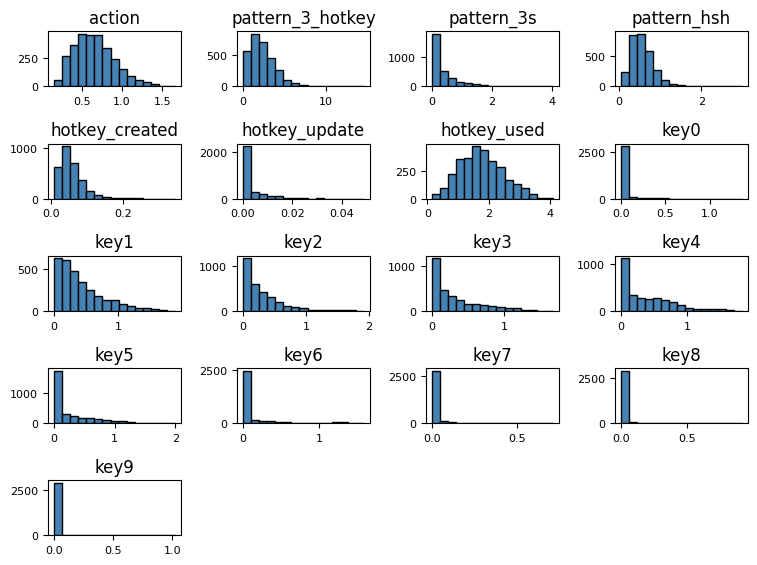

In [10]:
# Data visualization
# Histograms

new_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

We got almost Gaussian distribution on action and hotkey_used. In fact, these features highly correlate with the game length, since most actions are hotkey_used and there are more actions in longer games. With a sufficiently large dataset (more than 3000 rows), we can observe a closely normally distributed game length. 
## 2.2. Bar plot of Base
Below is frequency of 

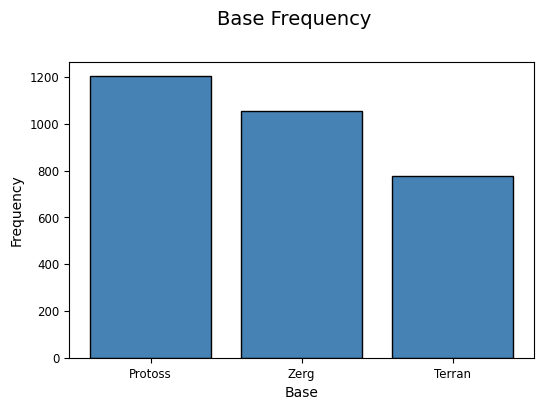

In [11]:
# Bar Plot
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Base Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Base")
ax.set_ylabel("Frequency") 
w_q = new_df['race'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=1)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


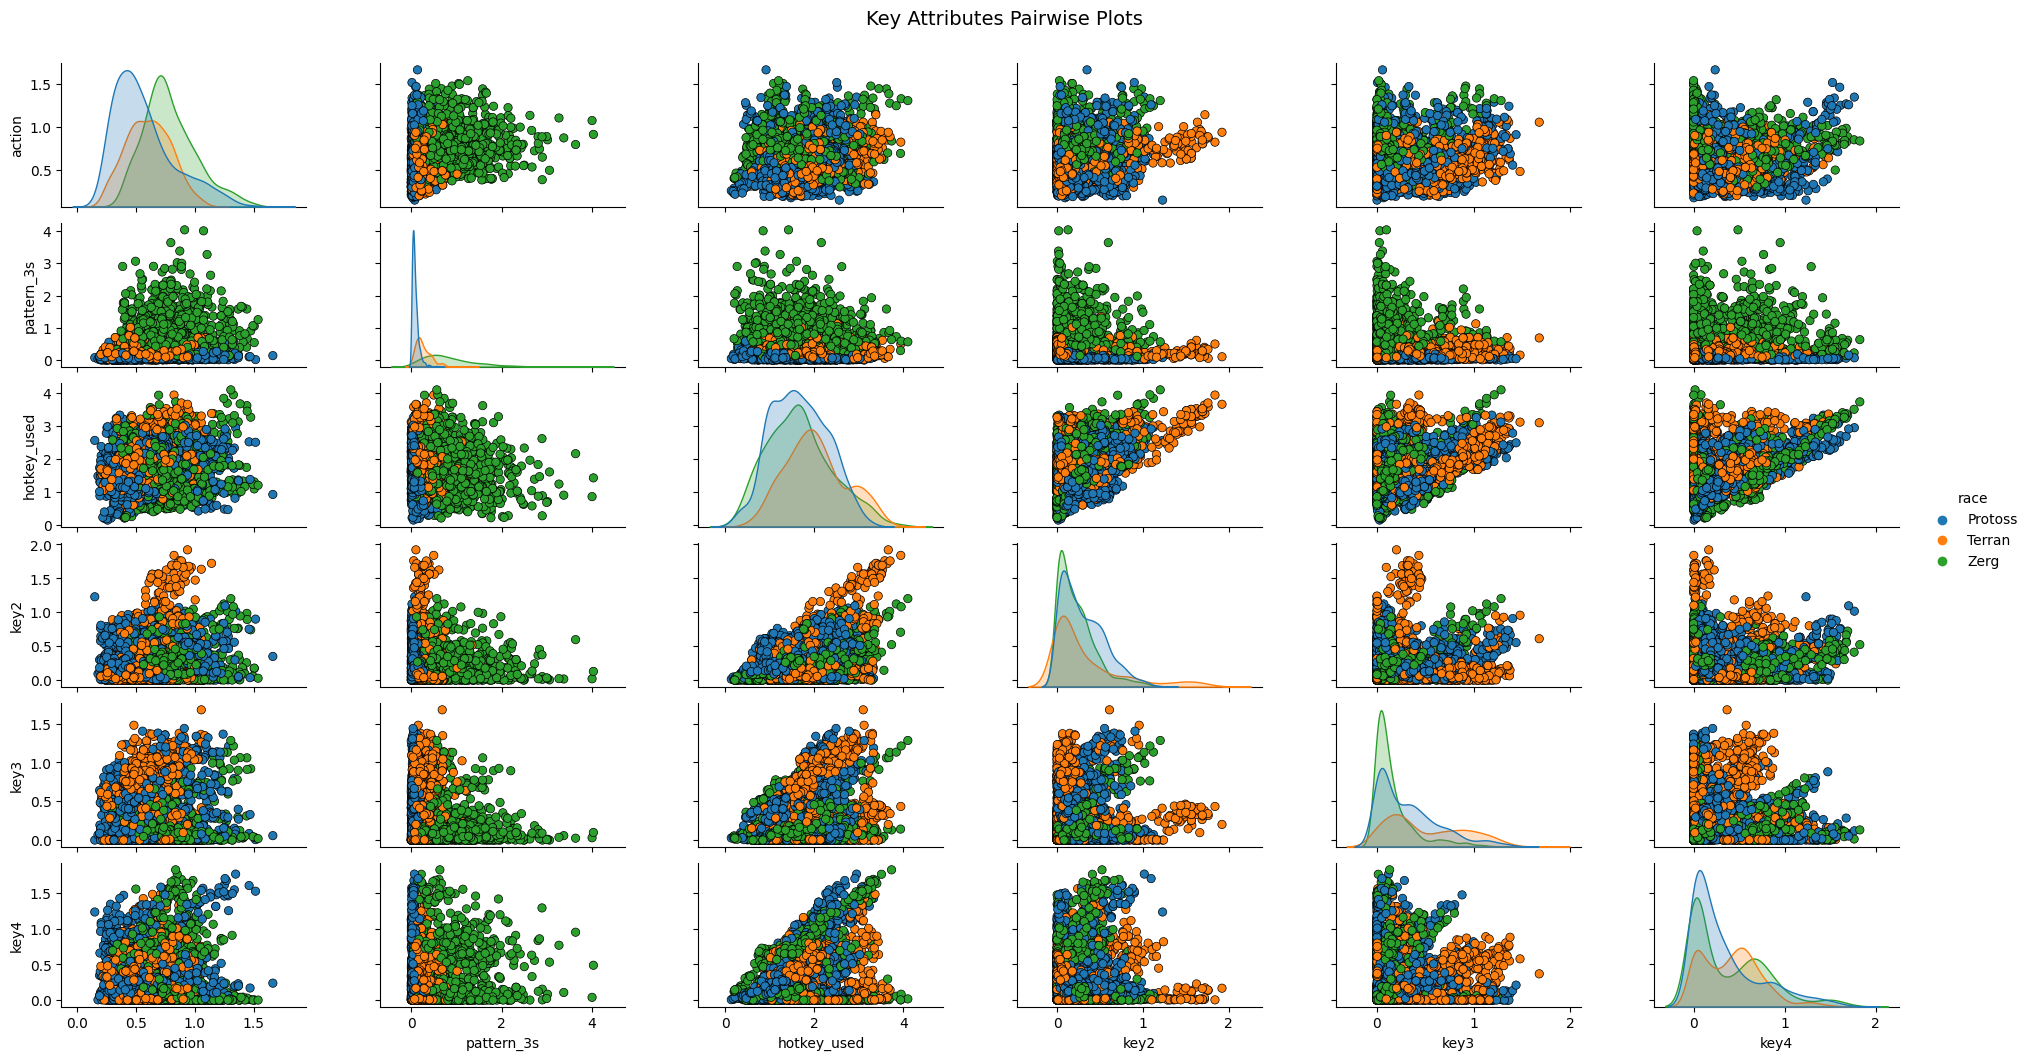

In [12]:
# Pair-wise Scatter Plots
cols = ['action', 'pattern_3s','hotkey_used', 'key2', "key3","key4","race"]
pp = sns.pairplot(new_df[cols], hue = "race", height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(fill=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Key Attributes Pairwise Plots', fontsize=14)

In [17]:
# One-hot encode the specified columns
new_df = new_df.drop(columns = ['race'])

KeyError: "['race'] not found in axis"

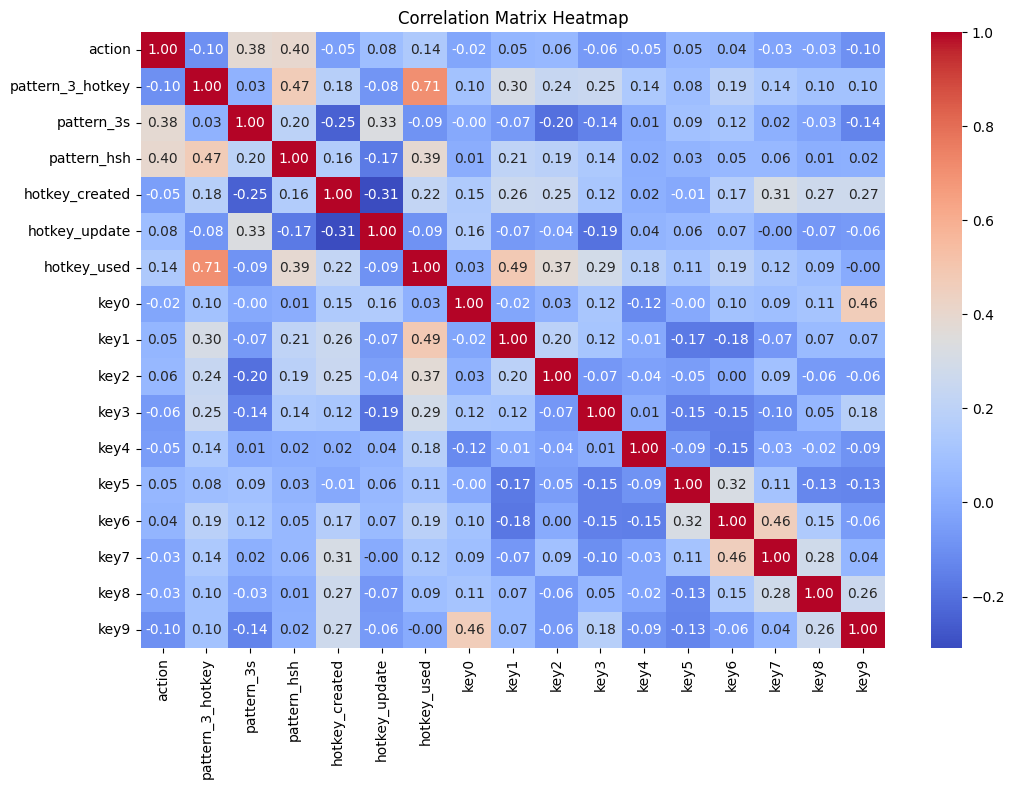

In [18]:
# Correlation matrix
correlation_matrix = new_df.iloc[:, 1:].corr(method='spearman')
# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
# Save the figure
plt.savefig('correlation_matrix.png') 
plt.show()

In [19]:
# X, y separation
X = new_df.iloc[:, 1:]  # Features (game information)
y = new_df.iloc[:, 0]   # Target variable (player's URL)

In [ ]:
# Apply PCA to calculate explained variance
pca = PCA()
X_pca = pca.fit_transform(X)

# Proportion of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame to display the results
df_explained_variance = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio})
df_explained_variance.index = [f'PC{i+1}' for i in range(len(explained_variance_ratio))]


In [ ]:
# Plotting the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot of Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

In [ ]:
# Create a DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca[:, :2], columns=['PC1', 'PC2'])
df_pca['Target'] = y

# Visualize the reduced data using a scatterplot
plt.figure(figsize=(8, 6))
targets = list(set(y))

for target in targets:
    indices_to_keep = df_pca['Target'] == target
    plt.scatter(df_pca.loc[indices_to_keep, 'PC1'],
                df_pca.loc[indices_to_keep, 'PC2'],
                label=target)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()

In [ ]:
# Apply LDA for dimensionality reduction (specify the desired number of components)
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

# Display the reduced dimensions
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_lda.shape}")

In [ ]:
# Create a DataFrame for plotting
df_lda = pd.DataFrame(data=X_lda[:, :2], columns=['LDA1', 'LDA2'])
df_lda['Target'] = y

# Visualize the reduced data using a scatterplot
plt.figure(figsize=(8, 6))
targets = list(set(y))

for target in targets:
    indices_to_keep = df_pca['Target'] == target
    plt.scatter(df_lda.loc[indices_to_keep, 'LDA1'],
                df_lda.loc[indices_to_keep, 'LDA2'],
                label=target)

plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.title('LDA Visualization')
plt.show()

In [ ]:
# KNN on LDA
# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X_lda, y, test_size=0.2, random_state=42)

# Train a classifier (K-Nearest Neighbors in this example)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_valid)

In [21]:
# Random Forest
# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)  # You can adjust the test_size


In [ ]:

from scipy.stats import randint
from sklearn.metrics import make_scorer, f1_score

# Define the parameter distributions for random search
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform random search with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, cv=5, scoring='f1_macro', n_iter=40, random_state=42, n_jobs=4)
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model on the test set
best_rf_model = random_search.best_estimator_


In [22]:
# Optimal Random Forest model
optimal_rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 88, random_state = 42)
optimal_rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=88, random_state=42)

In [23]:
y_pred = optimal_rf_model.predict(X_valid)

In [24]:
# Compute the F1 score
f1 = f1_score(y_valid, y_pred, average= 'macro')

# Print the F1 score
print(f1)

0.7929424638330272


In [ ]:
# Feature importances
importances = optimal_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in optimal_rf_model.estimators_], axis=0)

feature_names = list(X_train.columns)
forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending = False)
print(sorted_importances)

fig, ax = plt.subplots()
sorted_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
pip install treeinterpreter

In [ ]:
pip install waterfallcharts

In [ ]:
# How decision was made
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

prediction, bias, contributions = treeinterpreter.predict(optimal_rf_model, X_valid.values)
prediction.shape, bias.shape, contributions.shape


In [ ]:
def create_contrbutions_df(contributions, random_sample, feature_names, class_names):
    contribs = contributions[random_sample].tolist()
    contribs.insert(0, bias[random_sample])
    contribs = np.array(contribs)
    contrib_df = pd.DataFrame(data=contribs, index=["Base"] + feature_names, columns=class_names)
    prediction = contrib_df[class_names].sum()
    contrib_df.loc["Prediction"] = prediction
    return contrib_df


In [ ]:
random_sample = random.randint(1, len(X_valid))
class_names = optimal_rf_model.classes_
contrib_df = create_contrbutions_df(contributions, random_sample, feature_names, class_names)
contrib_df

In [ ]:
def display_prediction_information(index):
    target_value = y_valid.iloc[index]
    predicted_value = class_names[np.argmax(prediction[index])]
    print("Selected Sample     : %d"%index)
    print("Actual Target Value : %s"%target_value)
    print("Predicted Value     : %s"%predicted_value)
    return predicted_value,target_value

In [ ]:
predicted_value,target_value = display_prediction_information(random_sample)

In [ ]:
import plotly.graph_objects as go

def create_waterfall_chart(contrib_df, class_name, is_target = False):
    if is_target:
        name = "Target"
    else:
        name = "Prediction"
    fig = go.Figure(go.Waterfall(
        name = name, #orientation = "h", 
        measure = ["relative"] * (len(contrib_df)-1) + ["total"],
        x = contrib_df.index,
        y = contrib_df.loc[:, class_name],
        connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}}
    ))

    fig.update_layout(title = name + " : %s"%class_name)

    return fig

In [ ]:
create_waterfall_chart(contrib_df, predicted_value)

In [ ]:
# Find wrong predictions
wrong_predictions = []
for i in range (1, len(X_valid)):
    predicted_value = class_names[np.argmax(prediction[i])]
    target = y_valid.iloc[i]
    if target != predicted_value:
        wrong_predictions.append(i)  

In [ ]:
index_wrong_instance = random.choice(wrong_predictions)
display_prediction_information(index_wrong_instance)

In [ ]:
contrib_df = create_contrbutions_df(contributions, index_wrong_instance, feature_names, class_names)
predicted_value = class_names[np.argmax(prediction[index_wrong_instance])]
target_value = y_valid.iloc[index_wrong_instance]
create_waterfall_chart(contrib_df, target_value, True)

In [ ]:
create_waterfall_chart(contrib_df, predicted_value)

In [ ]:
# SVM
# Standardize the features (optional but recommended for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_valid)

In [ ]:
from scipy.stats import loguniform
# Define the SVM model
svm_model = SVC()

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'C': loguniform(1e-3, 1e3),        # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto', 'scale'],  # Kernel coefficient for 'rbf' kernel
    'degree': randint(2, 5),            # Degree for 'poly' kernel
    'shrinking': [True, False],         # Whether to use the shrinking heuristic
    'class_weight': [None, 'balanced'], # Class weights
}

# Create RandomizedSearchCV object
rand_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, cv=5, scoring='f1_macro', n_jobs=4)

# Fit the model to the training data
rand_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", rand_search.best_params_)
# Evaluate the model on the test set
best_svm_model = rand_search.best_estimator_


In [ ]:
# Make predictions on the test set
y_pred_svm = best_svm_model.predict(X_test_scaled)
# Compute the F1 score
f1 = f1_score(y_valid, y_pred_svm, average= 'macro')

# Print the F1 score
print(f1)

In [ ]:
# Create AdaBoostClassifier with DecisionTree base estimator
base_estimator = DecisionTreeClassifier(max_depth=50)
ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Define hyperparameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Number of estimators
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=ada_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42, n_jobs=4)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_ada_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_ada_model.predict(X_valid)


In [ ]:
# Compute the F1 score
f1 = f1_score(y_valid, y_pred, average= 'macro')

# Print the F1 score
print(f1)

In [ ]:
print(X)

In [ ]:
# Deep Neural Networks
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Encoding the target attribute for multi-class classification
le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# Normalize/Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Build the neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')  # Multi-class, so using 'softmax'
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=64, batch_size=32)

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
# Get predictions on the test set
y_pred_probs = model.predict(X_valid)

# Convert probabilities to class labels
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Inverse transform the predicted indices to original labels
decoded_labels = le.inverse_transform(y_pred_indices)

In [ ]:
# 'decoded_labels' now contains the original labels predicted by the model
print(decoded_labels)

In [ ]:
# Test data preparation

test_data = "/kaggle/input/projetdm-data/TEST.CSV"
### Loop the data lines
with open(test_data, 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
df_test = pd.read_csv(test_data,header=None, delimiter=",", names=column_names, low_memory=False).astype(str)
df_test.insert(0, '0', 0)
df_test.head()

In [ ]:
converted_test_data = df_test.values
output_test_data = extract_features(converted_test_data, is_test = True)


In [ ]:
new_test_df = pd.DataFrame(output_test_data, columns=headers)
# One-hot encode the specified columns
new_test_df = pd.get_dummies(new_test_df, columns=['race'])
X_test = new_test_df.iloc[:, 1:]  # Features (game information)
predictions = optimal_rf_model.predict(X_test)

In [ ]:
len(new_test_df)

In [ ]:
# Convert predictions to a DataFrame
submission_df = pd.DataFrame({'prediction': predictions})
submission_df['RowId'] = submission_df.index + 1 # Adding row IDs starting from 0

# Reorder the columns with 'RowID' as the first column
submission_df = submission_df[['RowId', 'prediction']]


# Save the DataFrame to a CSV file named 'submissions.csv'
submission_df.to_csv('submissions.csv', index=False)  